In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def score_sequence(mol):
    """Return (penalized_score, raw_survivors_in_region)."""
    
    n_x, n_y, n_z, is_lost, spin, mN = mol[:, 0], mol[:, 1], mol[:, 2], mol[:, 5], mol[:,4], mol[:,3]
    mask = (is_lost == 0) & (n_x == 0) & (n_y == 0) & (n_z == 0) & (spin == 0) & (mN == 1)
    raw = int(cp.count_nonzero(mask).get())
    return raw

### Check amplitude change in the original sequence

In [3]:
ori_seq = np.load("all_original.npy")

Raman pulses: 100%|██████████| 280/280 [00:52<00:00,  5.35it/s]


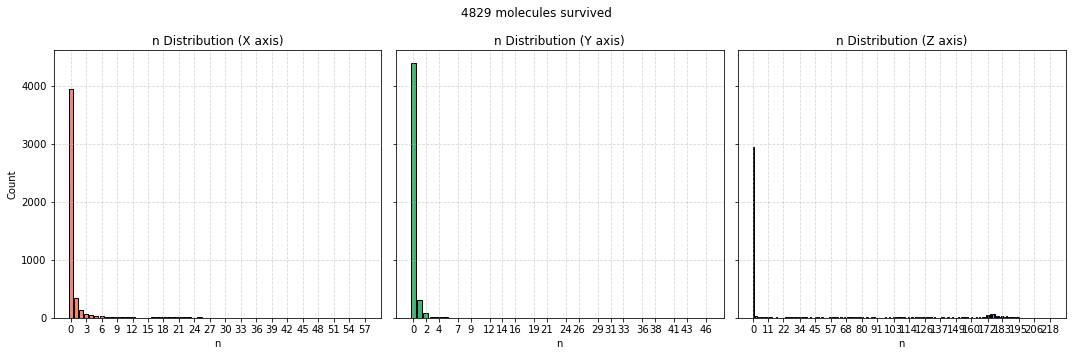

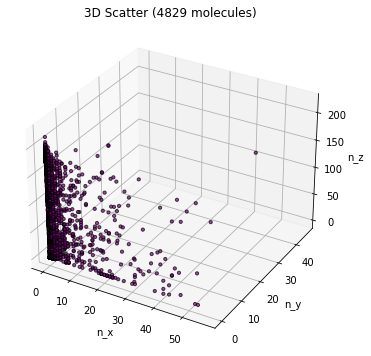

survival_rate_mean 0.4829
mot_mean [ 1.19879892  0.20770346 44.81362601]
mot_sem [0.00211126 0.00068077 0.03068077]
Ground state number 2802


In [4]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(10_000, temp)
cr.raman_cool_with_pumping(mol_0, ori_seq, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_0)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])
print("Ground state number", score_sequence(mol_0))

In [5]:
op_amps = np.load("amp_ga_runs/AMPGA_20251203_131958/final_top5/top1_sequence.npy")

Raman pulses: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s]


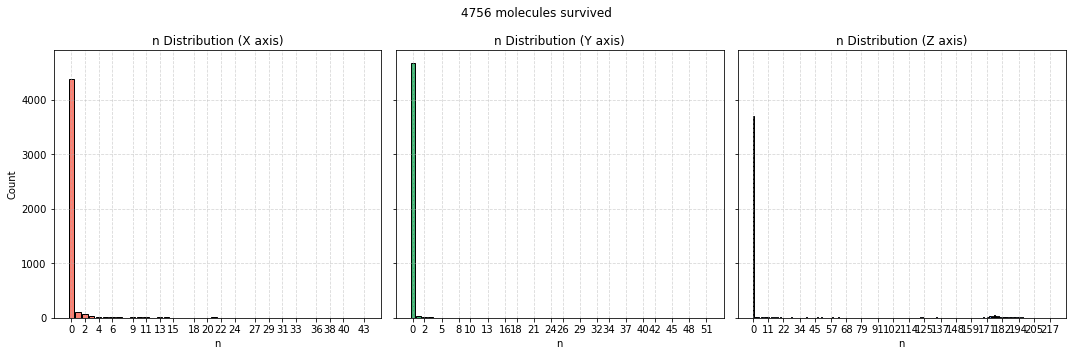

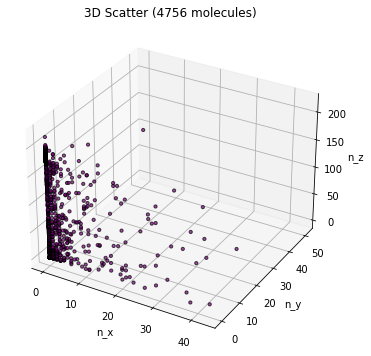

survival_rate_mean 0.4756
mot_mean [ 0.5235492   0.07275021 25.94785534]
mot_sem [0.00138945 0.00045702 0.02724273]
Ground state number 3688


In [6]:
temp = [25e-6, 25e-6, 25e-6]
mol_1 = cr.build_thermal_molecules_gpu(10_000, temp)
cr.raman_cool_with_pumping(mol_1, op_amps, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_1, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_1)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])
print("Ground state number", score_sequence(mol_1))

In [13]:
import json
seqs = []
for i in range(40):
    data = np.load(f"amp_ga_runs/AMPGA_20251203_131958/gen_{i:03d}/best_sequence.npy")
    seqs.append(np.unique(data, axis=0))
seqs = np.array(seqs)

In [29]:
import json
raw_survivals = []
for i in range(40):
    with open(f"amp_ga_runs/AMPGA_20251203_131958/gen_{i:03d}/meta.json") as file:
        meta = json.load(file)
        s = meta['raw_survivors']
        raw_survivals.append(s)

raw_survivals = np.array(raw_survivals)

In [17]:
seqs.shape[1]

11

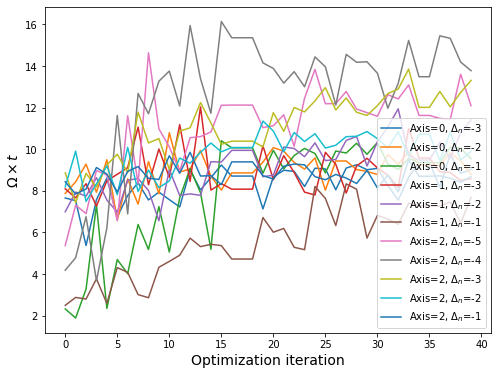

In [26]:
plt.figure(figsize=(8,6))
for i in range(seqs.shape[1]):
    plt.plot(np.arange(40), seqs[:,i,2], label=f"Axis={seqs[0,i,0]:.0g}, $\Delta_n$={seqs[0,i,1]:.0g}")
plt.xlabel("Optimization iteration", fontsize=14)
plt.ylabel(r"$\Omega\times t$", fontsize=14)
plt.legend()

Text(0, 0.5, 'Ground state rate')

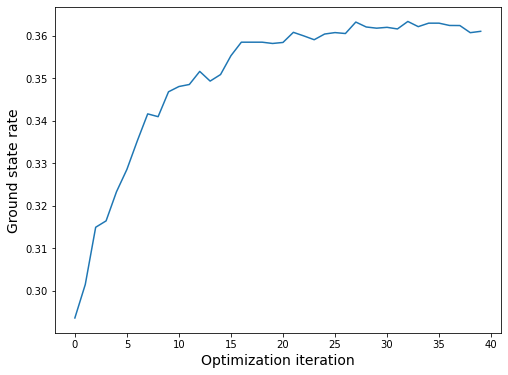

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(40), raw_survivals/50000)
plt.xlabel("Optimization iteration", fontsize=14)
plt.ylabel("Ground state rate", fontsize=14)

In [10]:
print(np.unique(ori_seq, axis=0))

[[ 0.         -3.          7.56309343]
 [ 0.         -2.          7.56309343]
 [ 0.         -1.          2.4933275 ]
 [ 1.         -3.          7.56309343]
 [ 1.         -2.          7.56309343]
 [ 1.         -1.          2.4933275 ]
 [ 2.         -5.          4.07243492]
 [ 2.         -4.          4.07243492]
 [ 2.         -3.          8.14486984]
 [ 2.         -2.          8.14486984]
 [ 2.         -1.          8.14486984]]


In [9]:
print(np.unique(op_amps, axis=0))

[[ 0.         -3.          7.55496441]
 [ 0.         -2.          9.27890282]
 [ 0.         -1.          9.02386655]
 [ 1.         -3.          8.16150278]
 [ 1.         -2.         11.93969585]
 [ 1.         -1.          6.39388693]
 [ 2.         -5.         12.4142115 ]
 [ 2.         -4.         13.16599906]
 [ 2.         -3.         12.88940504]
 [ 2.         -2.         10.84450558]
 [ 2.         -1.          7.94562814]]


### Check amplitude change in optimzed sequence

In [6]:
op_seq = np.load("sequence_optimized.npy")

Raman pulses:   0%|          | 0/185 [00:00<?, ?it/s]

Raman pulses: 100%|██████████| 185/185 [00:32<00:00,  5.65it/s]


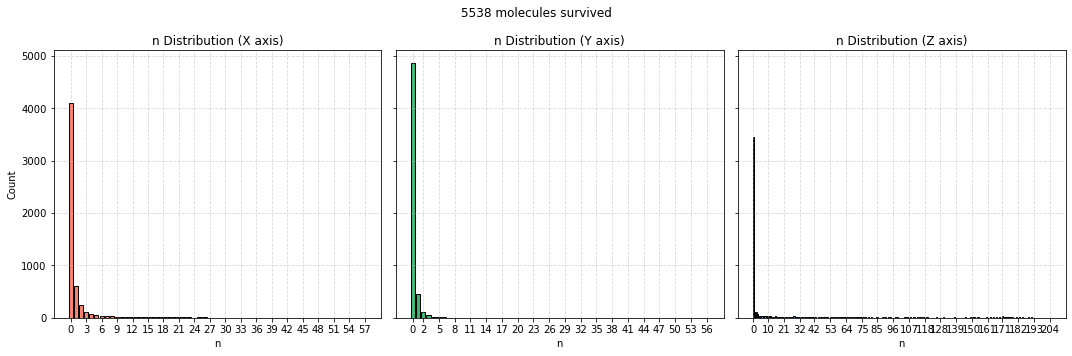

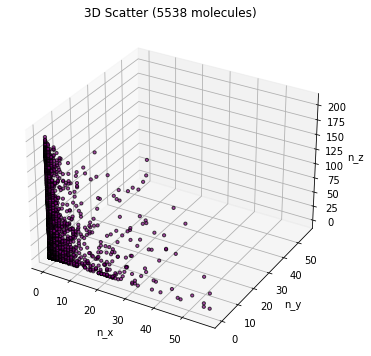

survival_rate_mean 0.5538
mot_mean [ 1.35734922  0.28060672 23.88678223]
mot_sem [0.0019747  0.00082275 0.0199638 ]
Ground state number 3083


In [7]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(10_000, temp)
cr.raman_cool_with_pumping(mol_0, op_seq, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_0)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])
print("Ground state number", score_sequence(mol_0))

In [9]:
op_amps = np.load("amp_ga_runs/AMPGA_20251203_111306/final_top5/top1_sequence.npy")

Raman pulses: 100%|██████████| 185/185 [00:32<00:00,  5.77it/s]


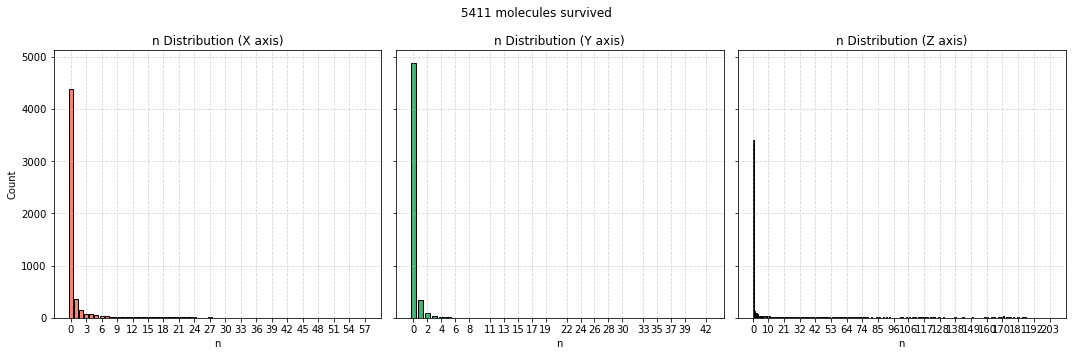

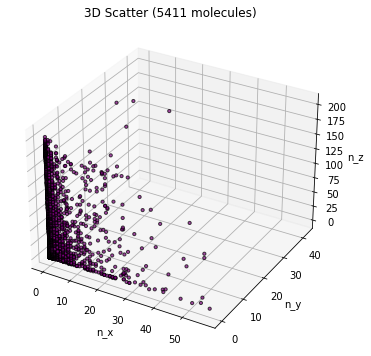

survival_rate_mean 0.5411
mot_mean [ 1.22269451  0.23637036 23.86046941]
mot_sem [0.00200362 0.00066997 0.02081296]
Ground state number 3261


In [10]:
temp = [25e-6, 25e-6, 25e-6]
mol_1 = cr.build_thermal_molecules_gpu(10_000, temp)
cr.raman_cool_with_pumping(mol_1, op_amps, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_1, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_1)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])
print("Ground state number", score_sequence(mol_1))